In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
#region Params
populationSize = 500
generations = 300
mutationRate = 0.1
defaultDays = 14
#endregion

In [3]:
#region Load And Clean
def loadAndCleanData(filePath, stayDays):
    data = pd.read_excel(filePath)
    data['price'] = data['price'].replace('[^0-9]', '', regex=True).astype(int)
    data['emissions'] = (
        data['emissions']
        .str.replace('[^0-9]', '', regex=True)
        .replace('', '0')
        .astype(int)
    )
    data['stops'] = data['stops'].replace({'nonstop': '0 stops'}, regex=False)
    data = data[data['stops'].str.contains('1 stop')]  # Filtrar solo vuelos con 1 parada
    data['days'] = stayDays
    return data
#endregion

In [4]:
#region Random Chromosome
def createChromosome(data):
    return random.choice(data.index)
#endregion

#region Fitness Function
def fitnessWithPenalty(chromosome, data):
    flight = data.loc[chromosome]
    priceScore = flight['price']
    stopsPenalty = int(flight['stops'].split()[0]) * 1000
    return priceScore + stopsPenalty
#endregion

#region Tournament Selection
def selection(population, fitnessScores):
    tournament = random.sample(list(zip(population, fitnessScores)), k=5)
    return min(tournament, key=lambda x: x[1])[0]
#endregion

#region Breed
def crossover(parent1, parent2):
    return random.choice([parent1, parent2])
#endregion

#region Chromosome Mutation
def mutate(chromosome, data):
    if random.random() < mutationRate:
        chromosome = random.choice(data.index)
    return chromosome
#endregion

In [5]:
#region Main GA
def geneticAlgorithmWithPenalty(data):
    # Population
    population = [createChromosome(data) for _ in range(populationSize)]
    
    for generation in range(generations):
        # Fitness With Penalties
        fitnessScores = [fitnessWithPenalty(chromosome, data) for chromosome in population]
        
        # New Population
        newPopulation = []
        for _ in range(populationSize // 2):
            parent1 = selection(population, fitnessScores)
            parent2 = selection(population, fitnessScores)
            child1 = mutate(crossover(parent1, parent2), data)
            child2 = mutate(crossover(parent2, parent1), data)
            newPopulation.extend([child1, child2])
        
        population = newPopulation
    
    # Find Best Being
    fitnessScores = [fitnessWithPenalty(chromosome, data) for chromosome in population]
    bestChromosome = population[fitnessScores.index(min(fitnessScores))]
    return bestChromosome, min(fitnessScores)
#endregion

In [6]:
#region Visualizations
def plotStatistics(data, bestFlight):
    # Extraer valores de interés
    min_price = data['price'].min()
    max_price = data['price'].max()
    min_emissions = data['emissions'].min()
    max_emissions = data['emissions'].max()
    
    best_price = data.loc[bestFlight, 'price']
    best_emissions = data.loc[bestFlight, 'emissions']
    
    # Gráfica de precios
    plt.figure(figsize=(12, 6))
    plt.hist(data['price'], bins=20, alpha=0.7, color='blue', label='Precios')
    plt.axvline(best_price, color='red', linestyle='--', linewidth=2, label=f'Mejor Precio: {best_price}')
    plt.axvline(min_price, color='green', linestyle='--', linewidth=2, label=f'Mínimo: {min_price}')
    plt.axvline(max_price, color='orange', linestyle='--', linewidth=2, label=f'Máximo: {max_price}')
    plt.title('Distribución de Precios de Vuelos')
    plt.xlabel('Precio (MX$)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Gráfica de emisiones
    plt.figure(figsize=(12, 6))
    plt.hist(data['emissions'], bins=20, alpha=0.7, color='blue', label='Emisiones')
    plt.axvline(best_emissions, color='red', linestyle='--', linewidth=2, label=f'Mejor Emisión: {best_emissions}')
    plt.axvline(min_emissions, color='green', linestyle='--', linewidth=2, label=f'Mínimo: {min_emissions}')
    plt.axvline(max_emissions, color='orange', linestyle='--', linewidth=2, label=f'Máximo: {max_emissions}')
    plt.title('Distribución de Emisiones de CO₂ de Vuelos')
    plt.xlabel('Emisiones (kg CO₂e)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()
#endregion

In [7]:
#region Flight Analysis
def main():
    filePath = "Ryokou\\Tokyo\\Tokyo.xlsx"
    stayDays = defaultDays
    flightData = loadAndCleanData(filePath, stayDays)
    
    if flightData.empty:
        print("\nNo se encontraron vuelos con una sola parada.")
        return
    
    print(f"\nAnalizando vuelos para una estancia de {stayDays} días y una sola parada...")
    bestFlight, bestCost = geneticAlgorithmWithPenalty(flightData)
    bestFlightData = flightData.loc[bestFlight]
    
    print("\nMejor vuelo encontrado:")
    print(bestFlightData)
    print(f"\nCosto total ajustado: MX${bestCost}")
    
    print("\nGenerando gráficas de distribución...")
    plotStatistics(flightData, bestFlight)
#endregion


Analizando vuelos para una estancia de 14 días y una sola parada...

Mejor vuelo encontrado:
departure_date                                                 3:22 PM
arrival_date                                                 3:20 PM+2
company              United, ANAOperated by SkyWest DBA United Express
duration                                                  32 hr 58 min
stops                                                           1 stop
emissions                                                        10962
price                                                            44202
price_type                                                  round trip
departure_airport                    Guadalajara International Airport
arrival_airport                      Guadalajara International Airport
date_added                                         2024-11-19 10:40:15
days                                                                14
Name: 1168, dtype: object

Costo total ajustado: MX$45

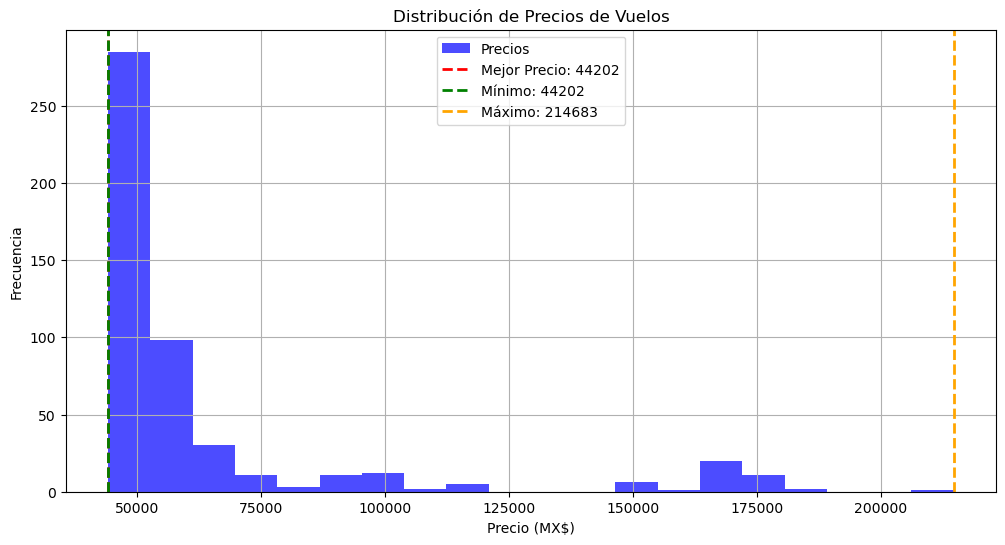

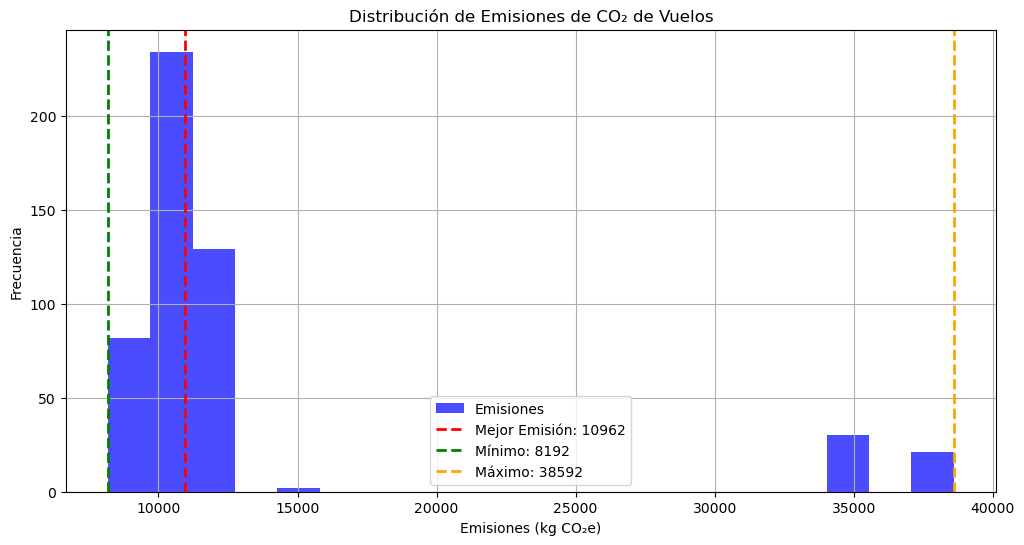

In [8]:
if __name__ == "__main__":
    main()